<div style="text-align:center"><span style="color:purple; font-family:helvetica; font-size:2.0em;">Bipedal Locomotion Control based on Divergent Component of Motion(DCM)</span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Importing the required libraries</span></div>

In [1]:
#In the following we import the classes that we need for simulation
import time
import pybullet as p#pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from FootTrajectoryRecovery import * # Foot trajectory generation Class
from RobotUtils import * # Class related to Inverse Kinematics 

from qpsolvers import solve_qp

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">First Part: A toy example for DCM and CoM motion planing</span></div>

c:\Users\begue\Desktop\LR\LRenv\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
c:\Users\begue\Desktop\LR\LRenv\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
c:\Users\begue\Desktop\LR\LRenv\lib\site-packages\qpsolvers\conversions\ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


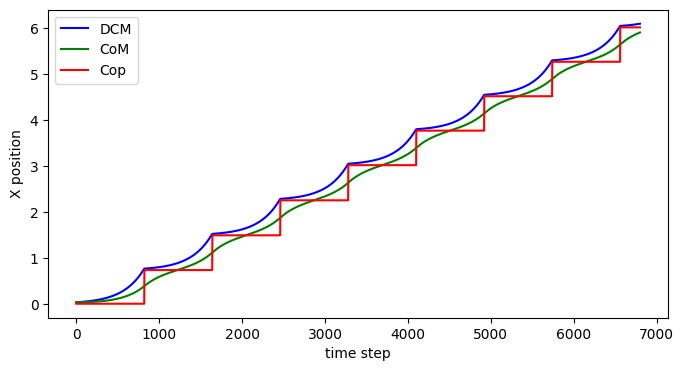

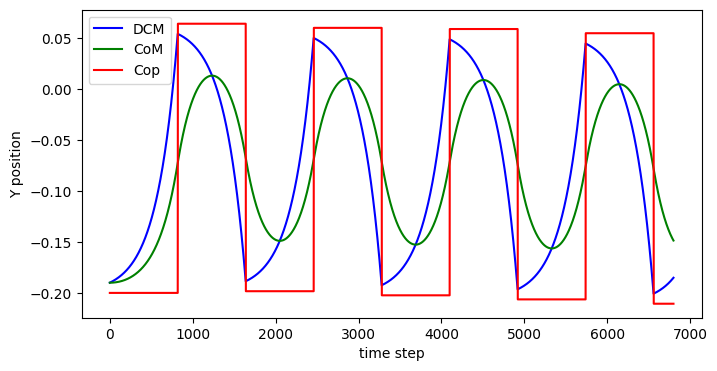

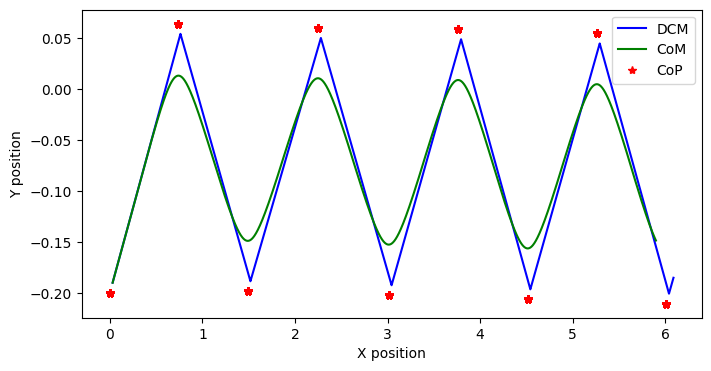

In [2]:
# todo: First start to fill and complete the DCMTrajectoryGenerator based on equation (3) and (9) of the project description
#then continue with the following part
NominalStepWidth=0.2#Nominal lateralDistanceOfFeet/2
NominalStepLength=0.4 # Nominal longitudinal distance between two sequential feet 
NominalStepDuration = 0.82# Nominal step duration 
CoMHeight=0.63 #constant center of mas height

dt_toy=0.001 # time step
DCMx=0.03 #initial DCM position in x direction
DCMy=-NominalStepWidth+0.01 #initial DCM position in y direction
CoPX=0.0 #initial CoP position in X direction
CoPY=-NominalStepWidth #initial CoP position in y direction

#create some lists for collecting data and plotting
DCMTrajectoryToy = list("")
CoMTrajectoryToy = list("")
CoPTrajectoryToy = list("")
ControlInputsToy = list("")

 
DCMGenerator = DCMTrajectoryGenerator(CoMHeight=CoMHeight)# todo: #We create an object of DCMTrajectoryGenerator Class
DCMGenerator.initialDCM = np.array([DCMx ,DCMy])
DCMGenerator.timeStep = dt_toy
DCMGenerator.CoM = np.array([DCMx ,DCMy])

stepNumber=0
sign=1 #for switching between right and left leg, could +1 for left foot in swing and or -1 if right foot is in swing
internalStep=0.0

deltaStepDurationMin= 0.3 # we substract this value from nominal step duration to find lower boundry of step duration constraint
deltaStepDurationMax= 1.3 # we add this value to nominal step duration to find upper boundry of step duration constraint

for iter in range(6800):
    alphaCoPX = 1.0
    alphaCoPY = 1.0
    alphaSigma = 1.0
    alphaOffsetX = 1000
    alphaOffsetY = 1000
    
    #CoP Nominal
    CoPNoMX = NominalStepLength + CoPX #CoPX is added here to add previous step position to the nominal step length
    CoPNoMY = sign*NominalStepWidth  #sign parameters switches between right and left foot
    
    OffsetNoMX = 0.03 #nominal DCM x offset
    OffsetNoMY = -1*sign*0.01 #nominal DCM  y offset
    SigmaNoM = math.exp(math.sqrt(9.81/CoMHeight)*NominalStepDuration) # todo: #nominal sigma (function of NominalStepDuration)

    #make a boundry limit for the next step position and duration 
    CoPTMaxX = CoPNoMX+0.4 #next step position maximum constraits for x
    CoPTMaxY = CoPNoMY+0.4 #next step position maximum constraits for y
    
    CoPTMinX = CoPNoMX-0.4 #next step position minimum constrait for x
    CoPTMinY = CoPNoMY-0.4 #next step position minimum constrait for y
    
    SigmaMin = math.exp(DCMGenerator.omega*(NominalStepDuration-deltaStepDurationMin))  # todo: use NominalStepDuration and deltaStepDurationMin
    SigmaMax = math.exp(DCMGenerator.omega*(NominalStepDuration+deltaStepDurationMax)) # todo: use NominalStepDuration and deltaStepDurationMax
        
    CopXInit = CoPX
    DCMXInit = DCMx
    CopYInit = CoPY
    DCMYInit = DCMy

    DCMGenerator.CoP = np.array([CoPX ,CoPY]) #update the initial CoP position in the DCMTrajectoryGenerator
    
    #make Hessian, Gradient and Constraints matrix of QP based on equations 13,14,15 and 16, 
    #you can expand these equations to find the follwoing matrices 
    P = np.diag(np.array([alphaCoPX, alphaCoPY ,alphaSigma, alphaOffsetX, alphaOffsetY]))# todo: use equation 14 and 16 to find the P and Q
    q = np.array([-alphaCoPX*CoPNoMX, 
                  -alphaCoPY*CoPNoMY, 
                  -SigmaNoM*alphaSigma, 
                  -alphaOffsetX*OffsetNoMX, 
                  -alphaOffsetY*OffsetNoMY]) # todo: use equation 14 and 16 to find the P and Q
    
    G = np.array([[1,0,0,0,0],
                  [0,1,0,0,0],
                  [-1,0,0,0,0],
                  [0,-1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,-1,0,0]]) # todo: use equation 15 and 16 to find the G and h
    
    
    h = np.array([[CoPTMaxX,CoPTMaxY,-CoPTMinX,-CoPTMinY,SigmaMax,-SigmaMin]]) #- G @ np.array([[CoPNoMX, CoPNoMY, OffsetNoMX, OffsetNoMY, SigmaNoM]])# todo: use equation 15 and 16 to find the G and h
    
    A = np.array([[1, 0, (CopXInit - DCMXInit), 1, 0],
                  [0, 1, (CopYInit - DCMYInit), 0, 1]])# todo: use equation 13 and 16 to find the A and b 
    b = np.array([[CopXInit],
                  [CopYInit]]) # todo: use equation 13 and 16 to find the A and b 
    
    #solve QP problem U is the vector of optimized parameters
    U = solve_qp(P, q, G, h, A, b, solver="osqp")
    
    stepDuration =  math.log(U[2])/DCMGenerator.omega #todo:find the step duration based on the the optimized sigma (use Log function to find step duration)
    
   
    DesiredDCM = DCMGenerator.getDCMTrajectory(dt_toy)  #get the desired DCM for the next time-step 
    DesiredCoM = DCMGenerator.getCoM() #get the desired CoM for the next time-step 
         
        
    DCMGenerator.initialDCM = np.array([DesiredDCM[0] ,DesiredDCM[1]])#set the current DCM position ad next initial dcm position 
    
    DCMTrajectoryToy.append(DesiredDCM)
    CoMTrajectoryToy.append(DesiredCoM)
    CoPTrajectoryToy.append(np.array([CoPX,CoPY]))
    ControlInputsToy.append(U)
    
    internalStep = internalStep+1 #is used for resetting the step parameters
    
    #resetting step parameters when step duration is finished
    if(dt_toy*internalStep>stepDuration):
        stepNumber=stepNumber+1
        internalStep=0
        DCMGenerator.CoP= np.array([U[0] ,U[1]])
        sign=sign*-1
    
        CoPX =U[0]
        CoPY =U[1]

        DCMx =DesiredDCM[0]
        DCMy =DesiredDCM[1]
        
  
# todo: uncomment to plot         
figg, (ax) = plt.subplots(figsize = (8, 4))
ax.plot(np.array(DCMTrajectoryToy)[:,0],'b',label="DCM")
ax.plot(np.array(CoMTrajectoryToy)[:,0],'g',label="CoM")
ax.plot(np.array(CoPTrajectoryToy)[:,0],'r',label="Cop")
ax.set_ylabel("X position")
ax.set_xlabel("time step")
ax.legend()
plt.show() 
figg1, (ax1) = plt.subplots(figsize = (8, 4))
ax1.plot(np.array(DCMTrajectoryToy)[:,1],'b',label="DCM")
ax1.plot(np.array(CoMTrajectoryToy)[:,1],'g',label="CoM")
ax1.plot(np.array(CoPTrajectoryToy)[:,1],'r',label="Cop")
ax1.set_ylabel("Y position")
ax1.set_xlabel("time step")
ax1.legend()
plt.show() 
figg2, (ax2) = plt.subplots(figsize = (8, 4))
ax2.plot(np.array(DCMTrajectoryToy)[:,0],np.array(DCMTrajectoryToy)[:,1],'b',label="DCM")
ax2.plot(np.array(CoMTrajectoryToy)[:,0],np.array(CoMTrajectoryToy)[:,1],'g',label="CoM")
ax2.plot(np.array(CoPTrajectoryToy)[:,0],np.array(CoPTrajectoryToy)[:,1],'*r',label="CoP")
ax2.set_xlabel("X position")
ax2.set_ylabel("Y position")
ax2.legend()
plt.show() 


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:2.37em;">Second Part: Push Recovery </span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Preparing Pybullet environment</span></div>

In [3]:
#In the following we create an object of dynamic engine of pybullet and we connect it to the Pybullet GUI
phisycsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [4]:
#In the following we load the urdf model of the robot and we specify the setting for the simulation
p.resetSimulation()
planeID = p.loadURDF("plane.urdf")
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)
p.setGravity(0,0,-9.81)
p.configureDebugVisualizer(p.COV_ENABLE_RGB_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_DEPTH_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_RENDER_CONTROLLERS,0)
p.configureDebugVisualizer(p.COV_ENABLE_Y_AXIS_UP,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_PICKING,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_TELEPORTING,0)
p.configureDebugVisualizer(p.COV_ENABLE_WIREFRAME,0)
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0) 
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
atlas=robotID = p.loadURDF("atlas/atlas_v4_with_multisense.urdf", [0,0,0.93],useFixedBase = 0)
p.setPhysicsEngineParameter()
p.setRealTimeSimulation(0)


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;"Locomotion Planning based on DCM</span></div>

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Initialization of the Robot</span></div>


In [5]:
AtlasUtils = RobotUtils()#This object is responsible for inverse kinematics
CoMHeight=0.63 #Constant pelvis(CoM) height
stepWidth=0.3#=lateralDistanceOfFeet/2
stepLength=0.57 #longitudinal distance between two sequential feet stepLength=stepStride/2, 
stepDuration = 0.43
dt=1.0/240.0
#Preparing the constant joints position for the upper-body joints
bodyPositions = [0.0,0.0,0.0,0.0]
leftArmIndex = [3,4,5,6,7,8,9]
rightArmIndex= [11,12,13,14,15,16,17]
bodyIndex = [0,1,2,10]
leftLegIndex=[18,19,20,21,22,23]
rightLegIndex=[24,25,26,27,28,29]
jointsIndex= np.zeros(30)
jointsPositions= np.zeros(30)
jointsIndex[0:4]=bodyIndex
jointsIndex[4:11]=rightArmIndex
jointsIndex[11:18]=leftArmIndex
jointsIndex[18:24]=rightLegIndex
jointsIndex[24:30]=leftLegIndex
jointsPositions[0:4]=bodyPositions


for i in range(1000):  #1000 sampling time will be allocated for the initialization of the robot position
    #Solving the inverse kinematic and sending the joints position command to the robot
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,0.9 - (i/1000)* (0.9-CoMHeight)], np.eye(3),[0.0,stepWidth,0.0], np.eye(3),[0.0, -stepWidth,0.0], np.eye(3))
    jointsPositions[24:30] =lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)

    p.stepSimulation()
    time.sleep(0.0002)

DCMTrajectory = list("")
basePos = list("")
DCM= list("")
comTrajectory = list("")
FeetTrajectoryLeft = list("")
FeetTrajectoryRight= list("")
prevLowerbodyJoints = lowerBodyJoints
time.sleep(1)#Just wait for a second

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;">Applying External Push and Estimating DCM</span></div>


In [6]:
gemId = p.loadURDF("boston_box.urdf", [-0.72, -0.0, 1.7],  p.getQuaternionFromEuler([0, 0, 0]))
gemId2 = p.loadURDF("boston_box.urdf", [-0.32, -0.3, 1.4],  p.getQuaternionFromEuler([0, 0, 0]))
# print(p.getBodyInfo(robotID) )
time.sleep(1)

#uncomment for saving video, there is another line that you also need to uncomment
#curr_recording = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4,"Test"+ ".mp4")

CoMPoS, robotOrn = p.getBasePositionAndOrientation(robotID)
CoMVel,_ = p.getBaseVelocity(robotID)
# print(CoMPoS+np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight ))
for i in range(23):
    gemPos, gemOrn = p.getBasePositionAndOrientation(gemId)
    force = np.array([873 ,0 ,0])
    p.applyExternalForce(objectUniqueId=gemId, linkIndex=-1,forceObj=force, posObj=gemPos, flags=p.WORLD_FRAME)
    gemPos2, gemOrn2 = p.getBasePositionAndOrientation(gemId2)
    force2 = np.array([0 ,1403 ,0])
    p.applyExternalForce(objectUniqueId=gemId2, linkIndex=-1,forceObj=force2, posObj=gemPos2, flags=p.WORLD_FRAME)
    p.stepSimulation()
    
    
    
    CoMPoS, robotOrn = p.getBasePositionAndOrientation(robotID)  #todo: receive the base position and orientation (use pybullet documentation for finding the related function) 
    CoMVel,_ = p.getBaseVelocity(robotID)  #todo: receive the base position velocity 
    basePos.append(CoMPoS)
    
    g = 9.81  # Acceleration due to gravity (you may need to adjust this value)
    DCM_position = np.asarray(CoMPoS) + np.asarray(CoMVel) / math.sqrt(g / CoMPoS[2])
    DCM_position = CoMPoS + np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight)
    DCM.append(DCM_position) #todo: append the DCM position based on CoM position and CoM velocity
time.sleep(0)
print(DCM[-1])
DCMError=DCM[-1]-DCM[0] # we find the DCM error of external force




[0.14530965 0.07615646 0.73722286]


In [7]:
# We detected push and DCM error in the previous code. 
#Here we use dcm error as initial DCM position to optimize the next step position and duration and then we apply that on the robot.
NominalStepWidth=0.7 #lateralDistanceOfFeet/2
NominalStepLength=0.7 #longitudinal distance between two sequential feet stepLength=stepStride/2, 
NominalStepDuration = 0.52

alphaCoPX = 1.0
alphaCoPY = 1.0
alphaSigma = 1.0
alphaOffsetX = 1000
alphaOffsetY =1000

#set nominal values
CoPNoMX = NominalStepLength
CoPNoMY = NominalStepWidth
OffsetNoMX = 0.0
OffsetNoMY = 0.0
SigmaNoM = math.exp(math.sqrt(9.81/CoMHeight )*(NominalStepDuration))

#set max an min values of constraints
CoPTMaxX = CoPNoMX+0.2
CoPTMaxY = CoPNoMY+0.2
CoPTMinX = CoPNoMX-0.2
CoPTMinY = CoPNoMY-0.2
SigmaMin =  math.exp(math.sqrt(9.81/CoMHeight)*(NominalStepDuration-0.23))
SigmaMax =  math.exp(math.sqrt(9.81/CoMHeight )*(NominalStepDuration+0.23))
    
#set initial conditions
CopXInit = 0.0
DCMXInit = DCMError[0]
CopYInit = 0.0
DCMYInit = DCMError[1]


#setup qp matrix
#make Hessian, Gradient and Constraints matrix of QP based on equations 13,14,15 and 16, 
#you can expand these equations to find the follwoing matrices 
P = np.diag(np.array([alphaCoPX, alphaCoPY ,alphaSigma, alphaOffsetX, alphaOffsetY]))# todo: use equation 14 and 16 to find the P and Q
q = np.array([-alphaCoPX*CoPNoMX, 
              -alphaCoPY*CoPNoMY, 
              -SigmaNoM*alphaSigma, 
              -alphaOffsetX*OffsetNoMX, 
              -alphaOffsetY*OffsetNoMY]) # todo: use equation 14 and 16 to find the P and Q

G = np.array([[1,0,0,0,0],
              [0,1,0,0,0],
              [-1,0,0,0,0],
              [0,-1,0,0,0],
              [0,0,1,0,0],
              [0,0,-1,0,0]]) # todo: use equation 15 and 16 to find the G and h


h = np.array([[CoPTMaxX,CoPTMaxY,-CoPTMinX,-CoPTMinY,SigmaMax,-SigmaMin]]) #- G @ np.array([[CoPNoMX, CoPNoMY, OffsetNoMX, OffsetNoMY, SigmaNoM]])# todo: use equation 15 and 16 to find the G and h

A = np.array([[1, 0, (CopXInit - DCMXInit), 1, 0],
                [0, 1, (CopYInit - DCMYInit), 0, 1]])# todo: use equation 13 and 16 to find the A and b 
b = np.array([[CopXInit],
              [CopYInit]]) # todo: use equation 13 and 16 to find the A and b 

com=p.getLinkState(robotID,0,computeLinkVelocity=1,computeForwardKinematics=1)
#QP solving using osqp solver
U = solve_qp(P, q, G, h, A, b, solver="osqp")


w = math.sqrt(9.81/ CoMHeight )
stepDuration=  math.log(U[2])/w #todo: find the step duration based on the the optimized sigma


#we implement the recovery step on the left foot, here we set the right and left feet positions
leftFootFinalPosition=np.empty((1, 3))

print(U)
leftFootFinalPosition[0][:] = np.array([U[0],U[1], 0.00]) #todo  use the control parameters to set the desired left foot position



leftFootStartPosition = np.empty((1, 3))
leftFootStartPosition[0][:]=[0*stepLength,stepWidth,-0.00]
rightFootPosition=np.empty((1, 3))
rightFootPosition[0][:]=[0*stepLength,-stepWidth,0.0]
leftFootPosition=np.empty((1, 3))
leftFootPosition[0][:]=[0*stepLength,stepWidth,0.0]


[ 5.89935514e-01  5.71750298e-01  7.80081253e+00 -1.10053685e-04
 -1.28280161e-04]


In [8]:

maximumFootHeight = 0.13 #The maximum height of swing foot during each step
FootRecovery=FootTrajectoryRecovery(stepDuration, maximumFootHeight) #We create an object of foot FootTrajectoryRecovery Class

DCMPushRecovery = DCMTrajectoryGenerator(CoMHeight) #We create an object of foot DCMTrajectoryGenerator Class
DCMPushRecovery.initialDCM = DCMError #DCMError todo: set the DCM error as the initial DCM position


for i in range(390):
    if(i>stepDuration*240): #in double support after push recovery just stand in place
        lowerBodyJoints=prevLowerbodyJoints
    else:
        MotionTime=dt*i
        DesiredDCM= DCMPushRecovery.getDCMTrajectory(MotionTime) #todo: get the dcm position
        DesiredCoM= DCMPushRecovery.getCoM() #todo: get the com position
        
        DCMTrajectory.append(DesiredDCM)
        comTrajectory.append(DesiredCoM)
        DesiredCoM3d=  np.append(DesiredCoM, DCMPushRecovery.CoMHeight) #make a 3d vector of com position by appending the com height
        
        #todo: get swing foot trajectory by using getSwingFootTrajectory function of FootRecovery, note dt=1.0/240.0 and time is increasing at each control cycle
        
        LeftFootPosition = FootRecovery.getSwingFootTrajectory(leftFootStartPosition, leftFootFinalPosition, MotionTime)
        lowerBodyJoints = AtlasUtils.doInverseKinematics(DesiredCoM3d, np.eye(3),LeftFootPosition, np.eye(3),rightFootPosition[0], np.eye(3))
        prevLowerbodyJoints=lowerBodyJoints#keep the previous joint position to use in the case of double support
    FeetTrajectoryLeft.append(LeftFootPosition)
    
    jointsPositions[24:30] = lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    # apply joint position on the robot (it will automatically implement joint PD)
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)
    p.stepSimulation()
    time.sleep(0.01)


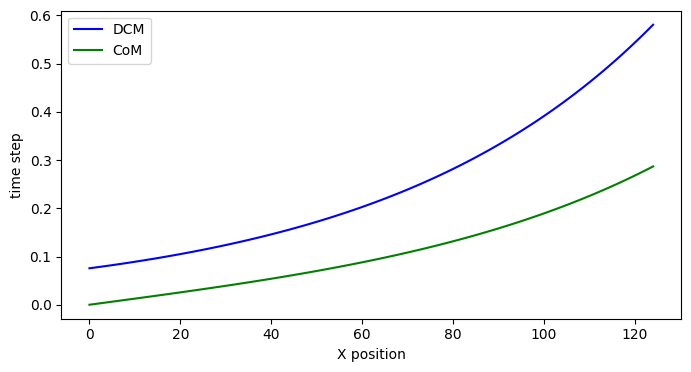

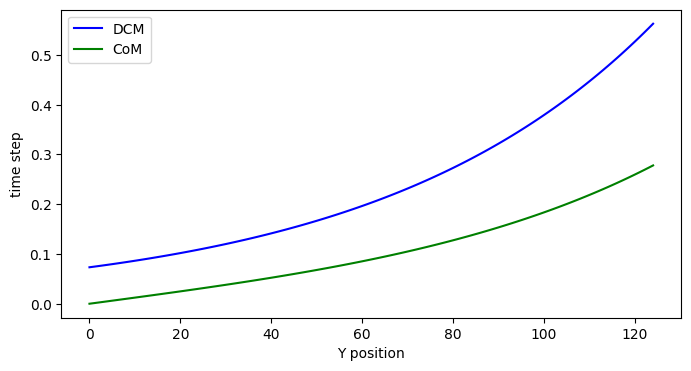

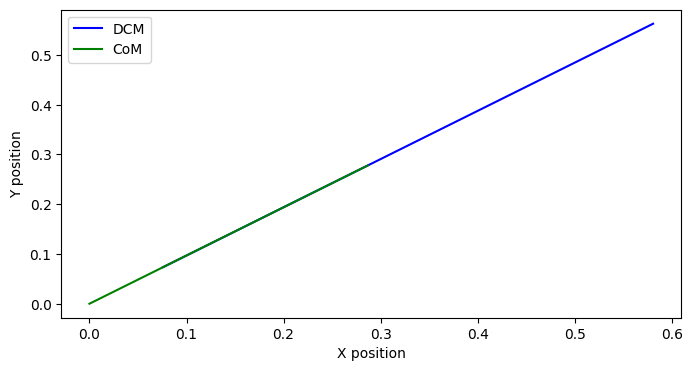

In [9]:
# Plot DCM and CoM Trajectory       
figg, (ax) = plt.subplots(figsize = (8, 4))
ax.plot(np.array(DCMTrajectory)[:,0],'b',label="DCM")
ax.plot(np.array(comTrajectory)[:,0],'g',label="CoM")

ax.set_xlabel("X position")
ax.set_ylabel("time step")
ax.legend()
plt.show() 
figg1, (ax1) = plt.subplots(figsize = (8, 4))
ax1.plot(np.array(DCMTrajectory)[:,1],'b',label="DCM")
ax1.plot(np.array(comTrajectory)[:,1],'g',label="CoM")

ax1.set_xlabel("Y position")
ax1.set_ylabel("time step")
ax1.legend()
plt.show() 
figg2, (ax2) = plt.subplots(figsize = (8, 4))
ax2.plot(np.array(DCMTrajectory)[:,0],np.array(DCMTrajectory)[:,1],'b',label="DCM")
ax2.plot(np.array(comTrajectory)[:,0],np.array(comTrajectory)[:,1],'g',label="CoM")

ax2.set_xlabel("X position")
ax2.set_ylabel("Y position")
ax2.legend()
plt.show() 

In [10]:
time.sleep(7)
p.disconnect()